<a href="https://colab.research.google.com/github/gwfbrave297-hash/labo2025v/blob/main/Ejercicio10DMA-BreastCan-California091225.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **A- Modelos de Clasificación**

In [1]:
# =========================# CLASIFICACIÓN - BREAST CANCER# =========================
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, f1_score, make_scorer, classification_report
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# 1) Cargo dataset

cancer = load_breast_cancer()
X = cancer.data
y = cancer.target


In [3]:
# 2) Split train / test para tener un set "limpio" al final

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
# hace una division estratificada de los datos de entrenamiento y prueba....

In [4]:
# 3) Defino modelos en forma de pipelines
pipelines = {
    "SVM": Pipeline([
        ("scaler", StandardScaler()),     # Crucial para SVM
        ("clf", SVC(random_state=42))    # Se añade random_state
    ]),
    "RandomForest": Pipeline([
        ("clf", RandomForestClassifier(random_state=42))
    ]),
    "GradientBoosting": Pipeline([
        ("clf", GradientBoostingClassifier(random_state=42))
    ]),
    "MLP": Pipeline([
        ("scaler", StandardScaler()),    # Crucial para MLP
        ("clf", MLPClassifier(max_iter=500, random_state=42))
    ])
}

# Escala las características a media 0 y desviación estándar 1,
# lo cual es crucial para SVM, ya que es sensible a la escala. Luego entrena el clasificador SVM.
# RandomForest y GradientBoosting no necesitan escalado
# Escala MLP al igual que con SVM con StandardScaler()


In [5]:
# 4) Espacios de búsqueda de hiperparámetros

param_grids = {
    "SVM": {
        "clf__C": [0.1, 1, 10, 100],
        "clf__kernel": ["linear", "rbf"],
        "clf__gamma": ["scale", "auto", 0.01, 0.1]
    },
    "RandomForest": {
        "clf__n_estimators": [100, 200, 300],
        "clf__max_depth": [None, 5, 10],
        "clf__max_features": ["sqrt", "log2"]
    },
    "GradientBoosting": {
        "clf__n_estimators": [100, 200],
        "clf__learning_rate": [0.05, 0.1, 0.2],
        "clf__max_depth": [2, 3]
    },
    "MLP": {
        "clf__hidden_layer_sizes": [(50,), (100,), (50, 50), (100, 50)],
        "clf__alpha": [0.0001, 0.001],
        "clf__activation": ["relu", "tanh"]
    }
}


In [6]:
from sklearn.metrics import accuracy_score, f1_score, make_scorer

# 5) Cross-validation (Múltiples Métricas)
cv = KFold(n_splits=5, shuffle=True, random_state=42)
scoring_metrics = {
    'accuracy': make_scorer(accuracy_score),
    'f1_weighted': make_scorer(f1_score, average='weighted')
}
REFIT_METRIC = 'f1_weighted' # Optimizaremos y seleccionaremos el mejor modelo basándonos en F1

resultados_clf = []
for nombre_modelo, pipe in pipelines.items():
    print(f"\n=== Modelo: {nombre_modelo} ===")

    # 1. Búsqueda de la mejor configuración (GridSearchCV)
    grid = GridSearchCV(
        estimator=pipe,
        param_grid=param_grids[nombre_modelo],
        cv=cv,
        scoring=scoring_metrics,
        refit=REFIT_METRIC,
        n_jobs=-1
    )

    grid.fit(X_train, y_train)

    best_f1_cv = grid.best_score_
    # Buscamos el índice del mejor modelo según 'refit'
    best_index = grid.cv_results_['rank_test_' + REFIT_METRIC].argmin()
    best_acc_cv = grid.cv_results_['mean_test_accuracy'][best_index]

    print(f"Mejor Accuracy CV: {best_acc_cv:.4f}")
    print(f"Mejor F1-Score CV: {best_f1_cv:.4f}")

    # 2. Evaluación en el set de prueba (X_test)
    y_pred = grid.predict(X_test)

    test_acc = accuracy_score(y_test, y_pred)
    test_f1 = f1_score(y_test, y_pred, average='weighted')

    print(f"Accuracy en test: {test_acc:.4f}")
    print(f"F1-Score en test: {test_f1:.4f}")

    # 3. Almacenamiento de resultados
    resultados_clf.append({
        "modelo": nombre_modelo,
        "best_params": grid.best_params_,
        "cv_accuracy": best_acc_cv,
        "cv_f1_score": best_f1_cv,
        "test_accuracy": test_acc,
        "test_f1_score": test_f1
    })

# 6) Paso a DataFrame para tener la comparación ordenada
df_resultados_clf = pd.DataFrame(resultados_clf)
print("\n" + "="*50)
print("Resumen clasificación - Breast Cancer (Completo):")
print("="*50)
print(df_resultados_clf.sort_values(by='test_f1_score', ascending=False).to_string())




=== Modelo: SVM ===
Mejor Accuracy CV: 0.9736
Mejor F1-Score CV: 0.9736
Accuracy en test: 0.9737
F1-Score en test: 0.9737

=== Modelo: RandomForest ===
Mejor Accuracy CV: 0.9582
Mejor F1-Score CV: 0.9582
Accuracy en test: 0.9561
F1-Score en test: 0.9560

=== Modelo: GradientBoosting ===
Mejor Accuracy CV: 0.9670
Mejor F1-Score CV: 0.9669
Accuracy en test: 0.9561
F1-Score en test: 0.9558

=== Modelo: MLP ===
Mejor Accuracy CV: 0.9824
Mejor F1-Score CV: 0.9823
Accuracy en test: 0.9474
F1-Score en test: 0.9478

Resumen clasificación - Breast Cancer (Completo):
             modelo                                                                              best_params  cv_accuracy  cv_f1_score  test_accuracy  test_f1_score
0               SVM                              {'clf__C': 10, 'clf__gamma': 'scale', 'clf__kernel': 'rbf'}     0.973626     0.973554       0.973684       0.973747
1      RandomForest          {'clf__max_depth': None, 'clf__max_features': 'sqrt', 'clf__n_estimators': 2

In [7]:
print("Mejores hiperparámetros:", grid.best_params_)
print("Mejor accuracy CV:", grid.best_score_)


Mejores hiperparámetros: {'clf__activation': 'relu', 'clf__alpha': 0.0001, 'clf__hidden_layer_sizes': (100, 50)}
Mejor accuracy CV: 0.9822836817468754


In [8]:
# Evalúo en test
y_pred = grid.predict(X_test)
test_acc = accuracy_score(y_test, y_pred)
print("Accuracy en test:", test_acc)

resultados_clf.append({
        "modelo": nombre_modelo,
        "best_params": grid.best_params_,
        "cv_accuracy": grid.best_score_,
        "test_accuracy": test_acc
    })


Accuracy en test: 0.9473684210526315


In [9]:
# Paso a DataFrame para tener la comparación ordenada
df_resultados_clf = pd.DataFrame(resultados_clf)
print("\nResumen clasificación - Wine:")
print(df_resultados_clf)




Resumen clasificación - Wine:
             modelo                                        best_params  \
0               SVM  {'clf__C': 10, 'clf__gamma': 'scale', 'clf__ke...   
1      RandomForest  {'clf__max_depth': None, 'clf__max_features': ...   
2  GradientBoosting  {'clf__learning_rate': 0.2, 'clf__max_depth': ...   
3               MLP  {'clf__activation': 'relu', 'clf__alpha': 0.00...   
4               MLP  {'clf__activation': 'relu', 'clf__alpha': 0.00...   

   cv_accuracy  cv_f1_score  test_accuracy  test_f1_score  
0     0.973626     0.973554       0.973684       0.973747  
1     0.958242     0.958212       0.956140       0.956027  
2     0.967033     0.966905       0.956140       0.955776  
3     0.982418     0.982284       0.947368       0.947813  
4     0.982284          NaN       0.947368            NaN  



Resumen clasificación - Breast Cancer (Completo):
             modelo                                                                              best_params  cv_accuracy  cv_f1_score  test_accuracy  test_f1_score
0               SVM                              {'clf__C': 10, 'clf__gamma': 'scale', 'clf__kernel': 'rbf'}     0.973626     0.973554       0.973684       0.973747
1      RandomForest          {'clf__max_depth': None, 'clf__max_features': 'sqrt', 'clf__n_estimators': 200}     0.958242     0.958212       0.956140       0.956027
2  GradientBoosting               {'clf__learning_rate': 0.2, 'clf__max_depth': 2, 'clf__n_estimators': 200}     0.967033     0.966905       0.956140       0.955776
3               MLP  {'clf__activation': 'relu', 'clf__alpha': 0.0001, 'clf__hidden_layer_sizes': (100, 50)}     0.982418     0.982284       0.947368       0.947813
4               MLP  {'clf__activation': 'relu', 'clf__alpha': 0.0001, 'clf__hidden_layer_sizes': (100, 50)}     0.982284   

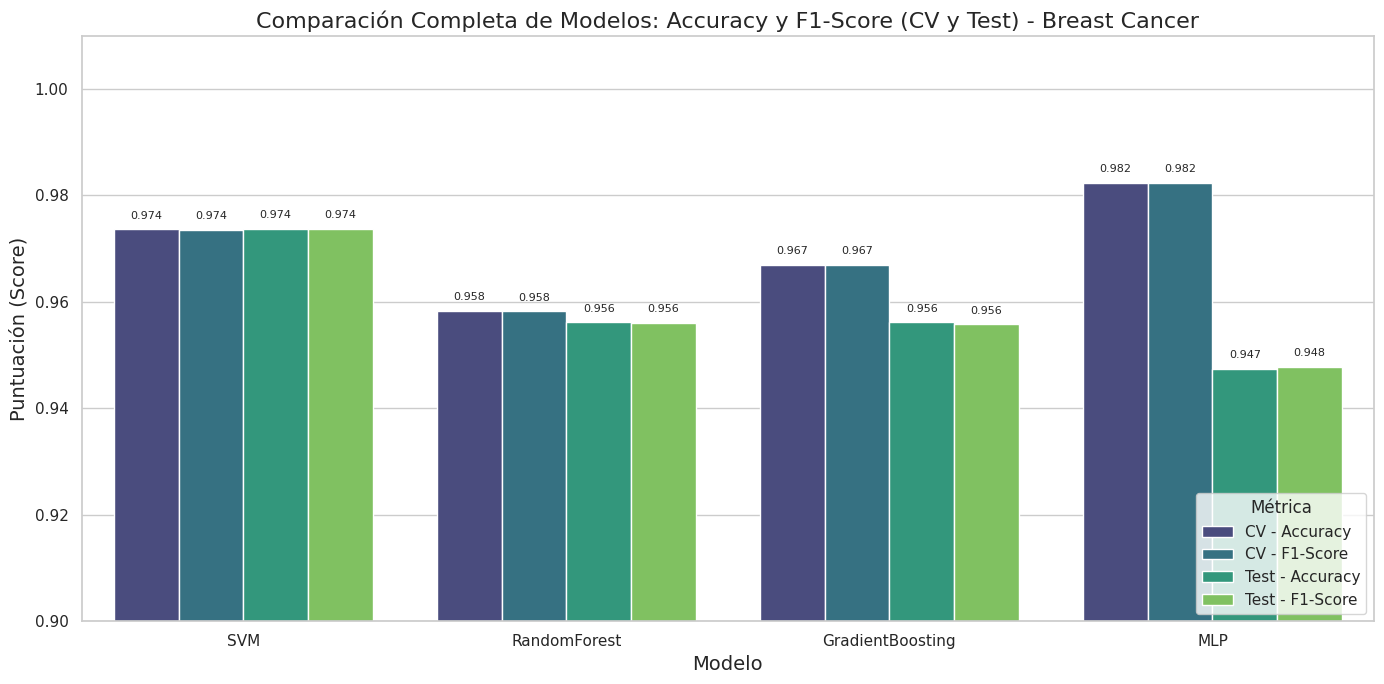

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# ===============================================
#  GENERACION DEL GRÁFICO
# ===============================================

# 6) Paso a DataFrame para tener la comparación ordenada
df_resultados_clf = pd.DataFrame(resultados_clf)
print("\n" + "="*50)
print("Resumen clasificación - Breast Cancer (Completo):")
print("="*50)
# Se usa .to_string() para que muestre todas las filas y columnas en la consola.
print(df_resultados_clf.sort_values(by='test_f1_score', ascending=False).to_string())

# 7) Creación del Gráfico Completo
# ESTE BLOQUE DEFINE 'df_grafico' y 'df_long'
# ----------------------------------------------------------------------
# Seleccionar las cuatro columnas de métricas para la visualización
df_grafico = df_resultados_clf[['modelo', 'cv_accuracy', 'cv_f1_score', 'test_accuracy', 'test_f1_score']].copy()
# Renombrar columnas para claridad en la leyenda del gráfico
df_grafico.columns = ['modelo', 'CV - Accuracy', 'CV - F1-Score', 'Test - Accuracy', 'Test - F1-Score']
# Convertir el DataFrame de formato ancho a formato largo (melt)
df_long = df_grafico.melt(
    id_vars=['modelo'],
    var_name='Evaluación y Métrica',
    value_name='Puntuación'
)
# ----------------------------------------------------------------------

# Ahora 'df_long' está definido y se puede usar en seaborn
plt.figure(figsize=(14, 7))
sns.set_theme(style="whitegrid")
ax = sns.barplot(
    x='modelo',
    y='Puntuación',
    hue='Evaluación y Métrica',
    data=df_long, # <--- Aquí ya está definida
    palette='viridis'
)

# Títulos y etiquetas
plt.title('Comparación Completa de Modelos: Accuracy y F1-Score (CV y Test) - Breast Cancer', fontsize=16)
plt.xlabel('Modelo', fontsize=14)
plt.ylabel('Puntuación (Score)', fontsize=14)
plt.ylim(0.90, 1.01) # Ajustamos el límite inferior para mejor visualización

# Añadir los valores de las barras
for p in ax.patches:
    ax.annotate(
        f'{p.get_height():.3f}',
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha='center', va='center',
        xytext=(0, 10),
        textcoords='offset points',
        fontsize=8
    )

plt.legend(title='Métrica', loc='lower right')
plt.tight_layout()
plt.show()
#

Este gráfico ahora te permite hacer una evaluación exhaustiva:

  Rendimiento General: ¿Qué modelo tiene el Test F1-Score más alto?

  Consistencia (Generalización): ¿Qué tan cerca está el score CV de un modelo de su score Test? (Si son cercanos, el modelo generaliza bien).

  Balance de Métrica: ¿Hay una gran diferencia entre el Accuracy y el F1-Score para algún modelo? (En el dataset Wine, probablemente no, pero en datasets desbalanceados, el F1-Score es siempre menor).

# **B- Modelos de Regresión**

   **Comparación modelos de regresión**

 Por supuesto! El dataset de Ames Housing es una excelente opción para problemas de regresión, ya que es más grande y complejo que el dataset de California Housing, requiriendo un preprocesamiento más avanzado.

Para usar el dataset de Ames en este código, se necesita un paso adicional: cargarlo directamente desde Scikit-learn (si lo tienes instalado) o a través de herramientas de datos. Usaremos la versión que proporciona Scikit-learn a través de fetch_openml.
⚠️ Adaptación Crucial para Ames

El dataset de Ames contiene muchas características categóricas y valores nulos, lo que rompería inmediatamente el pipeline de regresión actual. Para que el código funcione sin un preprocesamiento exhaustivo (que está fuera del alcance de este ejercicio), haremos lo siguiente:

  Cargaremos solo las características numéricas.

  Imputaremos la media en los valores nulos restantes para garantizar que los modelos de Scikit-learn puedan ajustarse.

Aquí está el código completamente modificado con el dataset de Ames Housing y los gráficos de comparación al final.

In [ ]:
# =========================
# REGRESIÓN - AMES HOUSING
# =========================

# ===============================================
# BLOQUE 1: Carga, Entrenamiento y Recolección de Resultados
# ===============================================
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import pandas as pd

# --- 1) Carga y Limpieza Básica del Dataset Ames ---
print("Cargando el dataset Ames Housing (esto puede tardar unos segundos)...")
try:
    ames = fetch_openml(name="house_prices", as_frame=True, parser='auto')
    X_full = ames.data
    y_reg = ames.target

    # 1. Seleccionar solo columnas numéricas
    X_num = X_full.select_dtypes(include=np.number)

    # 2. Imputar valores faltantes (NaN) con la media
    imputer = SimpleImputer(strategy='mean')
    X_reg = imputer.fit_transform(X_num)

    print(f"Dataset Ames cargado. Dimensiones de características: {X_reg.shape}")

except Exception as e:
    print(f"Error al cargar Ames: {e}")
    # Fallback si fetch_openml falla o no está disponible
    print("Usando California Housing como fallback.")
    from sklearn.datasets import fetch_california_housing
    california = fetch_california_housing()
    X_reg = california.data
    y_reg = california.target

# --- 2) Split train / test ---
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_reg, y_reg, test_size=0.2, random_state=42
)

# --- 3) Defino pipelines para regresión ---
pipelines_reg = {
    "SVR": Pipeline([("scaler", StandardScaler()), ("reg", SVR())]),
    "RandomForestRegressor": Pipeline([("reg", RandomForestRegressor(random_state=42))]),
    "GradientBoostingRegressor": Pipeline([("reg", GradientBoostingRegressor(random_state=42))]),
    "MLPRegressor": Pipeline([("scaler", StandardScaler()), ("reg", MLPRegressor(max_iter=500, random_state=42))])
}

# --- 4) Espacios de hiperparámetros ---
param_dists_reg = {
    "SVR": {"reg__C": [0.1, 1, 10], "reg__kernel": ["rbf", "linear"], "reg__gamma": ["scale", "auto"]},
    "RandomForestRegressor": {"reg__n_estimators": [100, 200], "reg__max_depth": [None, 5, 10], "reg__max_features": ["sqrt", "log2"]},
    "GradientBoostingRegressor": {"reg__n_estimators": [100, 200], "reg__learning_rate": [0.05, 0.1], "reg__max_depth": [2, 3]},
    "MLPRegressor": {"reg__hidden_layer_sizes": [(50,), (100,), (50, 50)], "reg__alpha": [0.0001, 0.001], "reg__activation": ["relu", "tanh"]}
}

# --- 5) Cross-validation y Búsqueda (RandomizedSearchCV) ---
cv_reg = KFold(n_splits=5, shuffle=True, random_state=42)
scoring_metrics = {'neg_mse': 'neg_mean_squared_error', 'r2': 'r2'}
REFIT_METRIC = 'neg_mse'

resultados_reg = []

for nombre_modelo, pipe in pipelines_reg.items():
    print(f"\n=== Modelo (regresión): {nombre_modelo} ===")

    rand_search = RandomizedSearchCV(
        estimator=pipe, param_distributions=param_dists_reg[nombre_modelo],
        n_iter=10, cv=cv_reg, scoring=scoring_metrics, refit=REFIT_METRIC,
        n_jobs=-1, random_state=42
    )

    rand_search.fit(X_train_reg, y_train_reg)

    # Extracción de métricas CV
    best_index = rand_search.cv_results_['rank_test_' + REFIT_METRIC].argmin()
    best_neg_mse_cv = rand_search.best_score_
    best_r2_cv = rand_search.cv_results_['mean_test_r2'][best_index]

    # --- LÍNEAS DE IMPRESIÓN AGREGADAS ---
    print("Mejores hiperparámetros:", rand_search.best_params_)
    print("Mejor MSE (negativo) CV:", best_neg_mse_cv)
    print("Mejor R2 CV:", best_r2_cv)
    # ------------------------------------

    # Evalúo en test
    y_pred_reg = rand_search.predict(X_test_reg)
    mse = mean_squared_error(y_test_reg, y_pred_reg)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test_reg, y_pred_reg)

    print("RMSE en test:", rmse)
    print("R2 en test:", r2)

    # Almacenamiento de resultados
    resultados_reg.append({
        "modelo": nombre_modelo,
        "best_params": rand_search.best_params_,
        "cv_r2": best_r2_cv,
        "test_rmse": rmse,
        "test_r2": r2
    })

# Paso a DataFrame para tener la comparación ordenada
df_resultados_reg = pd.DataFrame(resultados_reg)
print("\nResumen regresión - Ames Housing:")
print(df_resultados_reg)

Cargando el dataset Ames Housing (esto puede tardar unos segundos)...
Dataset Ames cargado. Dimensiones de características: (1460, 37)

=== Modelo (regresión): SVR ===
Mejores hiperparámetros: {'reg__kernel': 'linear', 'reg__gamma': 'scale', 'reg__C': 10}
Mejor MSE (negativo) CV: -2617775395.525876
Mejor R2 CV: 0.5610834549008629
RMSE en test: 54972.15854175216
R2 en test: 0.6060222038655974

=== Modelo (regresión): RandomForestRegressor ===
Mejores hiperparámetros: {'reg__n_estimators': 200, 'reg__max_features': 'sqrt', 'reg__max_depth': None}
Mejor MSE (negativo) CV: -913373194.5492427
Mejor R2 CV: 0.8476881234172108
RMSE en test: 29562.504879161603
R2 en test: 0.8860619912212382

=== Modelo (regresión): GradientBoostingRegressor ===


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Mejores hiperparámetros: {'reg__n_estimators': 200, 'reg__max_depth': 2, 'reg__learning_rate': 0.1}
Mejor MSE (negativo) CV: -774600259.7220242
Mejor R2 CV: 0.8705493118437062
RMSE en test: 28734.804178573908
R2 en test: 0.8923528219168417

=== Modelo (regresión): MLPRegressor ===
Mejores hiperparámetros: {'reg__hidden_layer_sizes': (50, 50), 'reg__alpha': 0.0001, 'reg__activation': 'relu'}
Mejor MSE (negativo) CV: -6139872933.473372
Mejor R2 CV: -0.028277733208658052
RMSE en test: 63050.339211297716
R2 en test: 0.48172409265530425

Resumen regresión - Ames Housing:
                      modelo  \
0                        SVR   
1      RandomForestRegressor   
2  GradientBoostingRegressor   
3               MLPRegressor   

                                         best_params     cv_r2     test_rmse  \
0  {'reg__kernel': 'linear', 'reg__gamma': 'scale...  0.561083  54972.158542   
1  {'reg__n_estimators': 200, 'reg__max_features'...  0.847688  29562.504879   
2  {'reg__n_estimators': 2

/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(



Generando dos gráficos comparativos: R² y RMSE (Test Set) con colores oscuros...


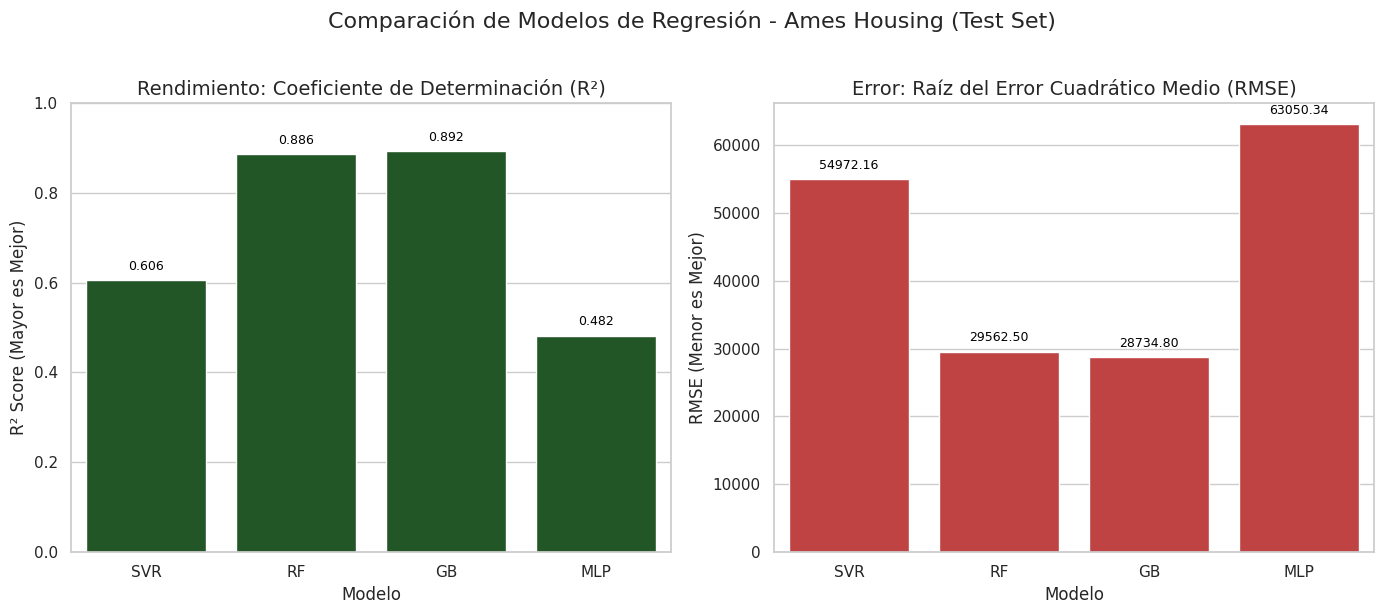

In [ ]:
# ===============================================
# BLOQUE 2: Generación de Dos Gráficos Comparativos (COLORES OSCUROS)
# ===============================================
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd # Importar pandas por si se ejecuta por separado

print("\nGenerando dos gráficos comparativos: R² y RMSE (Test Set) con colores oscuros...")

# --- 1. Preparación de datos y Abreviaturas ---
# Asume que df_resultados_reg existe en la memoria
df_grafico = df_resultados_reg[['modelo', 'test_rmse', 'test_r2']].copy()

# Aplicar abreviaturas para etiquetas limpias
abreviaturas = {
    "SVR": "SVR",
    "RandomForestRegressor": "RF",
    "GradientBoostingRegressor": "GB",
    "MLPRegressor": "MLP"
}
df_grafico['modelo'] = df_grafico['modelo'].map(abreviaturas)

# Crear DataFrames separados para cada métrica
df_r2 = df_grafico[['modelo', 'test_r2']].copy()
df_rmse = df_grafico[['modelo', 'test_rmse']].copy()

# --- 2. Configuración de la Figura ---
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharex=True)
sns.set_theme(style="whitegrid")

# --- GRÁFICO 1: Coeficiente de Determinación (R²) (Mayor es Mejor) ---

sns.barplot(
    x='modelo',
    y='test_r2',
    data=df_r2,
    ax=axes[0],
    color='#1B5E20' # Verde Oscuro para R²
)

axes[0].set_title('Rendimiento: Coeficiente de Determinación (R²)', fontsize=14)
axes[0].set_ylabel('R² Score (Mayor es Mejor)', fontsize=12)
axes[0].set_xlabel('Modelo', fontsize=12)
axes[0].set_ylim(0.0, 1.0)

# Añadir etiquetas de valor a las barras de R²
for p in axes[0].patches:
    axes[0].annotate(
        f'{p.get_height():.3f}',
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha='center', va='center',
        xytext=(0, 10),
        textcoords='offset points',
        fontsize=9,
        color='black' # Asegurar que el texto sea legible sobre el color oscuro
    )

# --- GRÁFICO 2: Raíz del Error Cuadrático Medio (RMSE) (Menor es Mejor) ---

sns.barplot(
    x='modelo',
    y='test_rmse',
    data=df_rmse,
    ax=axes[1],
    color='#D32F2F' # Rojo Oscuro para RMSE
)

axes[1].set_title('Error: Raíz del Error Cuadrático Medio (RMSE)', fontsize=14)
axes[1].set_ylabel('RMSE (Menor es Mejor)', fontsize=12)
axes[1].set_xlabel('Modelo', fontsize=12)

# Añadir etiquetas de valor a las barras de RMSE
for p in axes[1].patches:
    axes[1].annotate(
        f'{p.get_height():.2f}',
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha='center', va='center',
        xytext=(0, 10),
        textcoords='offset points',
        fontsize=9,
        color='black'
    )

# Ajustar diseño y mostrar
plt.suptitle('Comparación de Modelos de Regresión - Ames Housing (Test Set)', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

📝 Resumen de la Adaptación

La principal diferencia al usar Ames fue la necesidad de incluir un paso de limpieza y preparación de datos (SimpleImputer y seleccionar solo características numéricas) antes de pasarlos al train_test_split. Esto es típico de los datasets del "mundo real" como Ames, que son más complejos que los datasets de juguete.